#Project scope

Data source for this project is the cardiovascular detection dataset from kaggle. This dataset contains 70,000 rows and 12 explanatory variables and binary response variable that we'll be using for classification

The purpose of this project is to utilize PySpark functions for data extraction, feature engineering and machine learning algorithms to determine whether or not an individual potentially has a cardiovascular disease.

#Setup and libraries

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=54968199c542d6e7bb006a8791053e0a452bb431451a6b1ad435c6697fcf2a66
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, expr, count, when, isnan, skewness
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, ChiSqSelector, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.functions import *
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns
import numpy as np

In [3]:
from pyspark.sql import SparkSession

In [6]:
from pyspark.sql.functions import col

In [4]:
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .config("spark.some.config.option", "config-value") \
    .getOrCreate()

#Data Preprocessing

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
csv_data = spark.read.format("csv")\
        .option("header","true")\
        .option("timestamp","true")\
        .option("delimiter",";")\
        .option("partitionBy", "ap_hi") \
        .load("/content/drive/MyDrive/cardio_train.csv")
csv_data = csv_data.withColumn("age", col("Age")/365)
print('Dataframe Preview')
csv_data.show(10)

Dataframe Preview
+---+------------------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|               age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+------------------+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|50.391780821917806|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1| 55.41917808219178|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2| 51.66301369863014|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|  3| 48.28219178082192|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|  4| 47.87397260273973|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
|  8|60.038356164383565|     1|   151|  67.0|  120|   80|          2|   2|    0|   0|     0|     0|
|  9|60.583561643835615|     1|   157|  93.0|  130|   80|          3|   1|    0|  

##Data mapping

In [11]:
def update_categorical(df, var_list, desc_mapping):
    df_updated = df
    for var in var_list:
        var_desc = desc_mapping.get(var)
        df_updated = df_updated.withColumn(f"{var}", var_desc[col(var)])
    return df_updated

expr_map = {
    'gender': expr("map('1', 'Women', '2', 'Men')"),
    'cholesterol': expr("map('1','Normal', '2','Above Normal', '3', 'Well Above Normal')"),
    'gluc': expr("map('1','Normal', '2','Above Normal', '3', 'Well Above Normal')"),
    'smoke': expr("map('0', 'No', '1', 'Yes')"),
    'active': expr("map('0', 'No', '1', 'Yes')"),
    'alco': expr("map('0', 'No', '1', 'Yes')"),
    'cardio': expr("map('0', 'No', '1', 'Yes')")
}

data_updated = update_categorical(csv_data, list(expr_map.keys()), expr_map)
data_updated.show(5)

+---+------------------+------+------+------+-----+-----+-----------------+------+-----+----+------+------+
| id|               age|gender|height|weight|ap_hi|ap_lo|      cholesterol|  gluc|smoke|alco|active|cardio|
+---+------------------+------+------+------+-----+-----+-----------------+------+-----+----+------+------+
|  0|50.391780821917806|   Men|   168|  62.0|  110|   80|           Normal|Normal|   No|  No|   Yes|    No|
|  1| 55.41917808219178| Women|   156|  85.0|  140|   90|Well Above Normal|Normal|   No|  No|   Yes|   Yes|
|  2| 51.66301369863014| Women|   165|  64.0|  130|   70|Well Above Normal|Normal|   No|  No|    No|   Yes|
|  3| 48.28219178082192|   Men|   169|  82.0|  150|  100|           Normal|Normal|   No|  No|   Yes|   Yes|
|  4| 47.87397260273973| Women|   156|  56.0|  100|   60|           Normal|Normal|   No|  No|    No|    No|
+---+------------------+------+------+------+-----+-----+-----------------+------+-----+----+------+------+
only showing top 5 rows



Mapping the categorical variables here to help better understand the data. All these columns will be one-hot encoded when preparing the ML pipeline.

In [24]:
cardio_data = data_updated\
                .withColumnRenamed("id", "ID").withColumn("ID", col("ID").cast("int"))\
                .withColumnRenamed("age", "Age").withColumn("Age", col("Age").cast("int"))\
                .withColumnRenamed("gender", "Gender").withColumn("Gender", col("Gender").cast("string"))\
                .withColumnRenamed("height", "Height").withColumn("Height", col("Height").cast("int"))\
                .withColumnRenamed("weight", "Weight").withColumn("Weight", col("Weight").cast("float"))\
                .withColumnRenamed("ap_hi", "SystolicBP").withColumn("SystolicBP", col("SystolicBP").cast("int"))\
                .withColumnRenamed("ap_lo", "DiastolicBP").withColumn("DiastolicBP", col("DiastolicBP").cast("int"))\
                .withColumnRenamed("cholesterol", "Cholesterol").withColumn("Cholesterol", col("Cholesterol").cast("string"))\
                .withColumnRenamed("gluc", "Glucose").withColumn("Glucose", col("Glucose").cast("string"))\
                .withColumnRenamed("smoke", "Smoking").withColumn("Smoking", col("Smoking").cast("string"))\
                .withColumnRenamed("alco", "Alcohol").withColumn("Alcohol", col("Alcohol").cast("string"))\
                .withColumnRenamed("active", "Active").withColumn("Active", col("Active").cast("string"))\
                .withColumnRenamed("cardio", "Cardio").withColumn("Cardio", col("Cardio").cast("string"))

cardio_data.cache()
print('Dataframe Structure')
print('----------------------------------')
print(cardio_data.printSchema())
print(' ')
print('Dataframe Preview')
print(cardio_data.show(5))

Dataframe Structure
----------------------------------
root
 |-- ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Weight: float (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- Cholesterol: string (nullable = true)
 |-- Glucose: string (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Active: string (nullable = true)
 |-- Cardio: string (nullable = true)

None
 
Dataframe Preview
+---+---+------+------+------+----------+-----------+-----------------+-------+-------+-------+------+------+
| ID|Age|Gender|Height|Weight|SystolicBP|DiastolicBP|      Cholesterol|Glucose|Smoking|Alcohol|Active|Cardio|
+---+---+------+------+------+----------+-----------+-----------------+-------+-------+-------+------+------+
|  0| 50|   Men|   168|  62.0|       110|         80|           Normal| Norm

Renaming the features for better interpretability and assigning correct datatype to them.

In [26]:
print('No of rows: ',cardio_data.count())
print('No of columns: ',len(cardio_data.columns))

No of rows:  70000
No of columns:  13


## Splitting the data into train and test sets to avoid data leakage

In [14]:
training, test = cardio_data.randomSplit([0.7,0.3], seed=128)

In [15]:
training.count()

49177

In [16]:
test.count()

20823

##Finding missing values

In [18]:
def find_missing(df):
    print("Count of Missing Values for Each Column ")
    df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

In [19]:
find_missing(training)

Count of Missing Values for Each Column 
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+
| ID|Age|Gender|Height|Weight|SystolicBP|DiastolicBP|Cholesterol|Glucose|Smoking|Alcohol|Active|Cardio|
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+
|  0|  0|     0|     0|     0|         0|          0|          0|      0|      0|      0|     0|     0|
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+



The data appears to be very clean, so no further adjustments will be needed at this. Note that if there were null values some of the following techniques would be applied to clean the dataset depending on the nature of the data:

- Drop rows (for a few missing rows)
- Drop columns (if the amount of missing values exceeds a threshold i.e. 30%)
- Mean/Median/Modal imputation

##Numerical data analysis

In [20]:
def get_statistics(df, var):
    print(var + " Statistics")
    stat_df = df.selectExpr(f"min({var}) as Min",
                           f"percentile_approx({var}, 0.5) as Median",
                           f"round(avg({var}), 1) as Mean",
                           f"max({var}) as Max").show()

In [21]:
for var in ['Age', 'SystolicBP', 'Height', 'Weight', 'DiastolicBP']:
    get_statistics(training, var)
    print(' ')

Age Statistics
+---+------+----+---+
|Min|Median|Mean|Max|
+---+------+----+---+
| 29|    53|52.9| 64|
+---+------+----+---+

 
SystolicBP Statistics
+----+------+-----+-----+
| Min|Median| Mean|  Max|
+----+------+-----+-----+
|-150|   120|128.5|14020|
+----+------+-----+-----+

 
Height Statistics
+---+------+-----+---+
|Min|Median| Mean|Max|
+---+------+-----+---+
| 57|   165|164.3|250|
+---+------+-----+---+

 
Weight Statistics
+----+------+----+-----+
| Min|Median|Mean|  Max|
+----+------+----+-----+
|11.0|  72.0|74.2|200.0|
+----+------+----+-----+

 
DiastolicBP Statistics
+---+------+----+-----+
|Min|Median|Mean|  Max|
+---+------+----+-----+
|  0|    80|96.7|11000|
+---+------+----+-----+

 


There appears to be a few observations worth looking at from these statistics.

The minimum height of an observed patient is recorded as 57cm  and one is recorded as high as 250cm.

The minimum weight of an observed patient is recorded as 11kg and one is recorded as high as 200kg.

Although these observations are a bit extreme, for the sake of this study it may not be necessary to remove those points and similar outliers. All these columns will be scaled later, and other tests will be done to determine if outliers should or should not be removed.

Looking at the Systolic and Diastolic Blood Pressure values, the max values are way higher than the mean and median values, and frankly quite impossible to reach medically. Normal blood pressure for most adults is defined as systolic pressure of less than 120 and a diastolic pressure of less than 80.

Another observation is that the min variables are negative, which is also problematic because Blood Pressure as a value cannot be theoretically lower than 0 mmHg for both Diastolic and Systolic BP (and in most practical situations a BP value of zero is extremely rare),

A potential reason for this is because the data point(s) may not have been recorded properly when creating the dataset or any equipment used to measure blood pressure was not calibrated properly. To determine what to do with these values it's best to check for overall skewness and find any outliers in our data.

##Analyzing outliers and skewness

In [22]:
def determine_skewness(df, var):
    print("Determining if " + var + " is skewed")
    skewness_val = df.select(skewness(var)).collect()[0][0]
    if skewness_val > 1 or skewness_val < -1:
        print("Column is highly skewed: " + str(skewness_val))
    else:
        print("Column is not highly skewed: " + str(skewness_val))

In [23]:
for var in ['Age', 'SystolicBP', 'Height', 'Weight', 'DiastolicBP']:
    determine_skewness(training, var)
    print(' ')

Determining if Age is skewed
Column is not highly skewed: -0.30663425633054536
 
Determining if SystolicBP is skewed
Column is highly skewed: 93.61487080197612
 
Determining if Height is skewed
Column is not highly skewed: -0.6065007084685093
 
Determining if Weight is skewed
Column is not highly skewed: 0.9924605480576734
 
Determining if DiastolicBP is skewed
Column is highly skewed: 32.82979030898495
 


Both Systolic and Diaostolic Blood Pressure appear to have high skewness, with Weight almost meeting the high skewness threshold.

In [28]:
def show_outliers(df, var, threshold=3, n=5):
    print("Number of Outliers for " + var)
    mean_var = df.agg({f"{var}": "avg"}).collect()[0][0]
    std_var = df.agg({f"{var}": "stddev"}).collect()[0][0]
    outliers_df = df.filter((col(var) - mean_var) / std_var > threshold)
    print(outliers_df.count())
    print("Rows with Outliers")
    outliers_df.show(n)

In [29]:
for var in ['Age', 'SystolicBP', 'Height', 'Weight', 'DiastolicBP']:
    show_outliers(training, var)
    print(' ')

Number of Outliers for Age
0
Rows with Outliers
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+
| ID|Age|Gender|Height|Weight|SystolicBP|DiastolicBP|Cholesterol|Glucose|Smoking|Alcohol|Active|Cardio|
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+
+---+---+------+------+------+----------+-----------+-----------+-------+-------+-------+------+------+

 
Number of Outliers for SystolicBP
27
Rows with Outliers
+-----+---+------+------+------+----------+-----------+------------+-------+-------+-------+------+------+
|   ID|Age|Gender|Height|Weight|SystolicBP|DiastolicBP| Cholesterol|Glucose|Smoking|Alcohol|Active|Cardio|
+-----+---+------+------+------+----------+-----------+------------+-------+-------+-------+------+------+
| 2654| 41| Women|   160|  60.0|       902|         60|      Normal| Normal|     No|     No|   Yes|    No|
| 2845| 62|   Men|   167|  59.0|       906|      

Here, we can see that all columns except age have outliers.

The outliers for weight, does not appear to be unreasonable (patients being 120kgs and being a part of this study is normal). Same can be said for height.

For the BPs we can see that there are a few BPs that impossible high (11500), however there are a few that are unreasonably high but appears more frequently i.e. Diastolic BP > 1000.

##Visualizing the distribution and skewness of the numerical features

In [32]:
def plot_hist(df, cols):
    num_cols = len(cols)
    df_pd = df.select(cols).toPandas()
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))
    for i, var in enumerate(df_pd.columns):
        axes[i].hist(df_pd[var], bins=10, color='red', alpha=0.7)
        axes[i].set_title(f"Histogram of {var}")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Frequency")
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

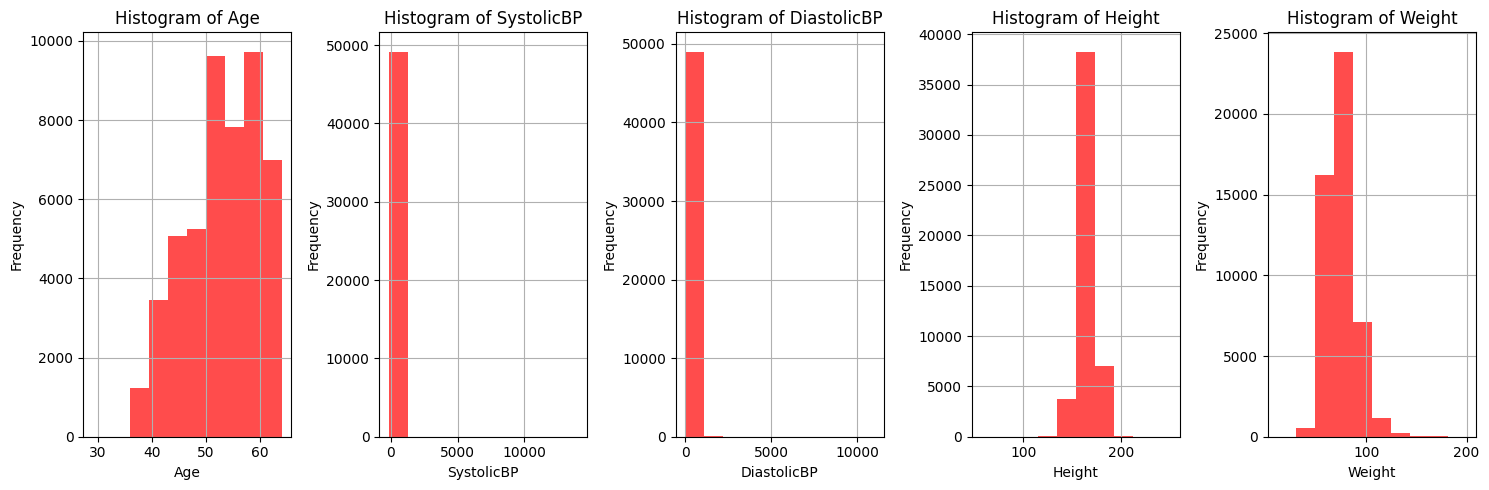

In [33]:
plot_hist(training, ["Age", "SystolicBP", "DiastolicBP", "Height", "Weight"])

The above histograms show the distribution of the numeric values. Height and Weight appear to follow a somewhat normal distribution. Age appears to be skewed towards the left. The two most concering graphs are related to the blood pressures. The graphs appear to be highly skewed to the right which further reinforces our concerns with regards to outliers.

In [35]:
def plot_boxplots(df, cols):
    num_cols = len(cols)
    df_pd = df.select(cols).toPandas()
    fig, axes = plt.subplots(1, num_cols, figsize=(15, 5))
    if num_cols == 1:
        axes = [axes]
    for i, var in enumerate(df_pd.columns):
        sns.boxplot(data=df_pd, y=var, ax=axes[i], color='lightblue')
        axes[i].set_title(f"Boxplot of {var}")
        axes[i].set_ylabel(var)
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

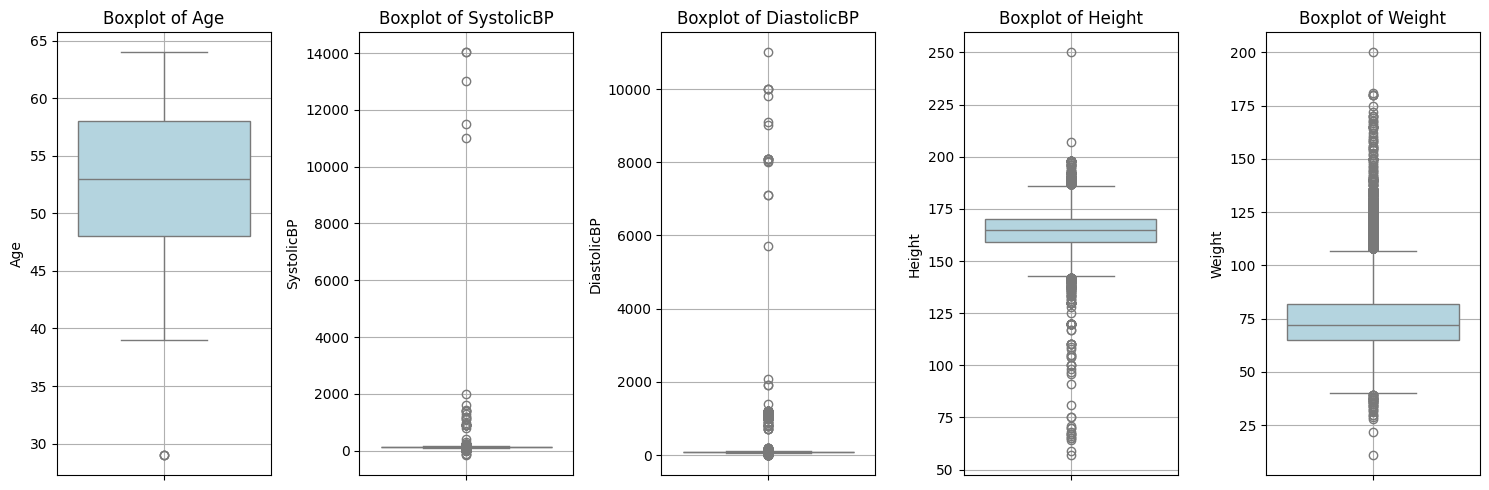

In [36]:
plot_boxplots(training, ["Age", "SystolicBP", "DiastolicBP", "Height", "Weight"])

The above boxplots show age not having as many outliers as compared to others. Outliers in systolicBP and diastolicBP makes it obvious why are highly right skewed.

##Treating outliers

###Binning

Binning is an effective technique to treat outliers, as they convert the continuous values to discrete. Additionaly, they also improve interpretability and improves overall integrity of the model.

Creating a function which bins systolicBP and diastolicBP accordingly.

**For systolicBP**                                       
* <90: Low Blood Pressure
* 90-119: Normal Blood Pressure
* 120-129: Elevated Blood Pressure
* 130-139: High Blood Pressure Stage 1
* 140 - 179: High Blood Pressure Stage 2
* 180+: Hyptertensive Crisis

**For diastolicBP**
* < 60: Low Blood Pressure
* 60 - 69: Normal Blood Pressure
* 70 - 79: Elevated Blood Pressure
* 80 - 89: High Blood Pressure Stage 1
* 90 - 119: High Blood Pressure Stage 2
* 120+: Hyptertensive Crisis


In [38]:
def bin_bp(df):
    df = df.withColumn("SystolicBP_Group", when(training['SystolicBP'] < 90, 'Low Blood Pressure') \
                        .when((training['SystolicBP'] >= 90) & (training['SystolicBP'] < 120), "Normal Blood Pressure") \
                        .when((training['SystolicBP'] >= 120) & (training['SystolicBP'] < 130), "Elevated Blood Pressure") \
                        .when((training['SystolicBP'] >= 130) & (training['SystolicBP'] < 140), "High Blood Pressure Stage 1") \
                        .when((training['SystolicBP'] >= 140) & (training['SystolicBP'] < 180), "High Blood Pressure Stage 2") \
                        .when(training['SystolicBP'] >= 180, "Hyptertensive Crisis") \
                        .otherwise("Unknown"))
    df = df.withColumn("DiastolicBP_Group", when(training['DiastolicBP'] < 60, 'Low Blood Pressure') \
                        .when((training['DiastolicBP'] >= 60) & (training['DiastolicBP'] < 70), "Normal Blood_Pressure") \
                        .when((training['DiastolicBP'] >= 70) & (training['DiastolicBP'] < 80), "Elevated Blood Pressure") \
                        .when((training['DiastolicBP'] >= 80) & (training['DiastolicBP'] < 90), "High Blood Pressure Stage 1") \
                        .when((training['DiastolicBP'] >= 90) & (training['DiastolicBP'] < 120), "High Blood Pressure Stage 2") \
                        .when(training['DiastolicBP'] >= 120, "Hyptertensive Crisis") \
                        .otherwise("Unknown"))
    return df

training_binned = bin_bp(training)
training_binned.select("DiastolicBP", "DiastolicBP_Group", "SystolicBP", "SystolicBP_Group").show(5, truncate=False)

+-----------+---------------------------+----------+---------------------------+
|DiastolicBP|DiastolicBP_Group          |SystolicBP|SystolicBP_Group           |
+-----------+---------------------------+----------+---------------------------+
|80         |High Blood Pressure Stage 1|110       |Normal Blood Pressure      |
|90         |High Blood Pressure Stage 2|140       |High Blood Pressure Stage 2|
|100        |High Blood Pressure Stage 2|150       |High Blood Pressure Stage 2|
|60         |Normal Blood_Pressure      |100       |Normal Blood Pressure      |
|90         |High Blood Pressure Stage 2|130       |High Blood Pressure Stage 1|
+-----------+---------------------------+----------+---------------------------+
only showing top 5 rows



##Categorical data analysis

In [39]:
def get_value_counts(df, var):
    N = df.select(var).distinct().count()
    print("Total number of unique values in " + var + ": " + str(N))
    print(var + " Value Counts")
    grouped_df = df.groupBy(var).count().withColumnRenamed('count', 'Count')
    grouped_df.orderBy(col(var).asc()).show(N)

In [40]:
for var in ['Glucose', 'Cholesterol', 'Gender', 'Smoking', 'Active', 'Alcohol', 'Cardio', 'DiastolicBP_Group', 'SystolicBP_Group']:
    get_value_counts(training_binned, var)
    print(' ')

Total number of unique values in Glucose: 3
Glucose Value Counts
+-----------------+-----+
|          Glucose|Count|
+-----------------+-----+
|     Above Normal| 3638|
|           Normal|41710|
|Well Above Normal| 3829|
+-----------------+-----+

 
Total number of unique values in Cholesterol: 3
Cholesterol Value Counts
+-----------------+-----+
|      Cholesterol|Count|
+-----------------+-----+
|     Above Normal| 6756|
|           Normal|36653|
|Well Above Normal| 5768|
+-----------------+-----+

 
Total number of unique values in Gender: 2
Gender Value Counts
+------+-----+
|Gender|Count|
+------+-----+
|   Men|17112|
| Women|32065|
+------+-----+

 
Total number of unique values in Smoking: 2
Smoking Value Counts
+-------+-----+
|Smoking|Count|
+-------+-----+
|     No|44919|
|    Yes| 4258|
+-------+-----+

 
Total number of unique values in Active: 2
Active Value Counts
+------+-----+
|Active|Count|
+------+-----+
|    No| 9633|
|   Yes|39544|
+------+-----+

 
Total number of 

In [41]:
def plot_bar(df, cols, label):
    df_pd = df.select(cols + [label]).toPandas()
    cross_tabs = {column: pd.crosstab(df_pd[column], df_pd[label]) for column in cols}
    fig, axes = plt.subplots(nrows=1, ncols=len(cross_tabs), figsize=(15, 6), sharey=True)
    colors = ['skyblue', 'salmon']
    for i, (column, cross_tab) in enumerate(cross_tabs.items()):
        cross_tab.plot(kind='bar', stacked=True, ax=axes[i], color=colors)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count')
        axes[i].set_title(f'Chart for {column} by {label}')
        axes[i].legend(title=label, labels=[f"Non-{label}", label])
        axes[i].grid(True)
        axes[i].tick_params(labelrotation=45)
    plt.tight_layout()
    plt.show()

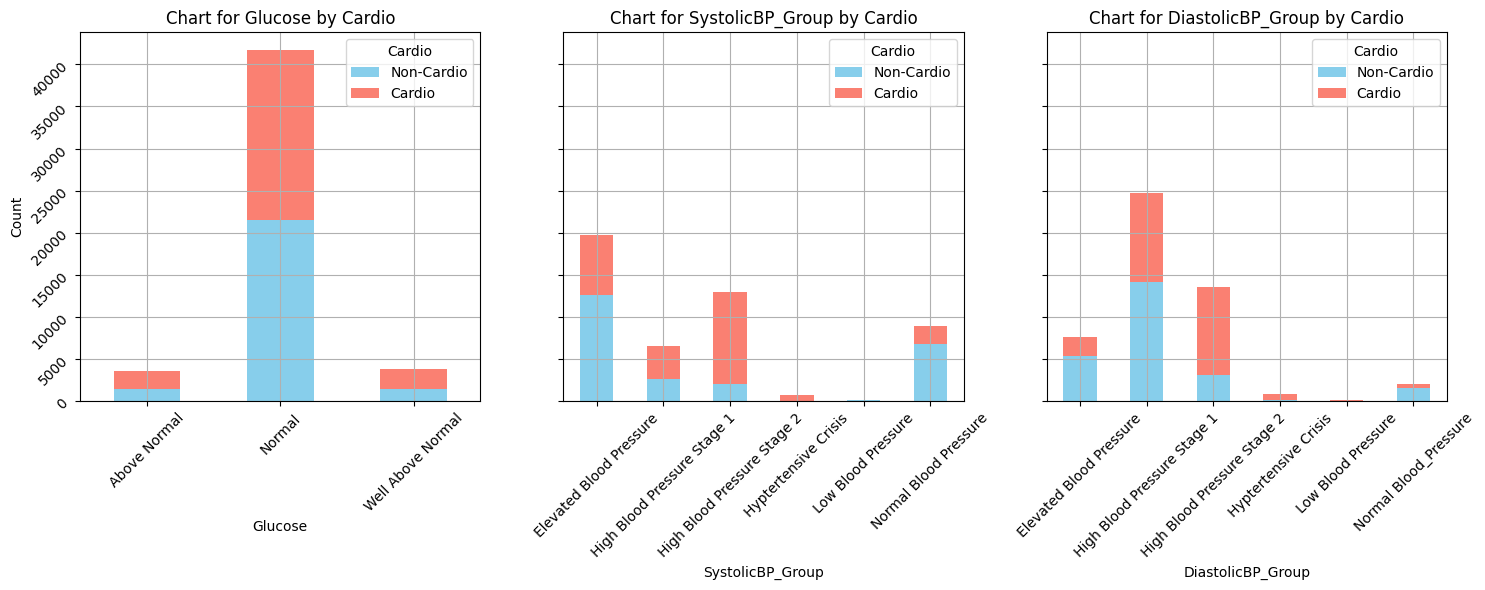

In [42]:
plot_bar(training_binned, ['Glucose', 'SystolicBP_Group', 'DiastolicBP_Group'], 'Cardio')

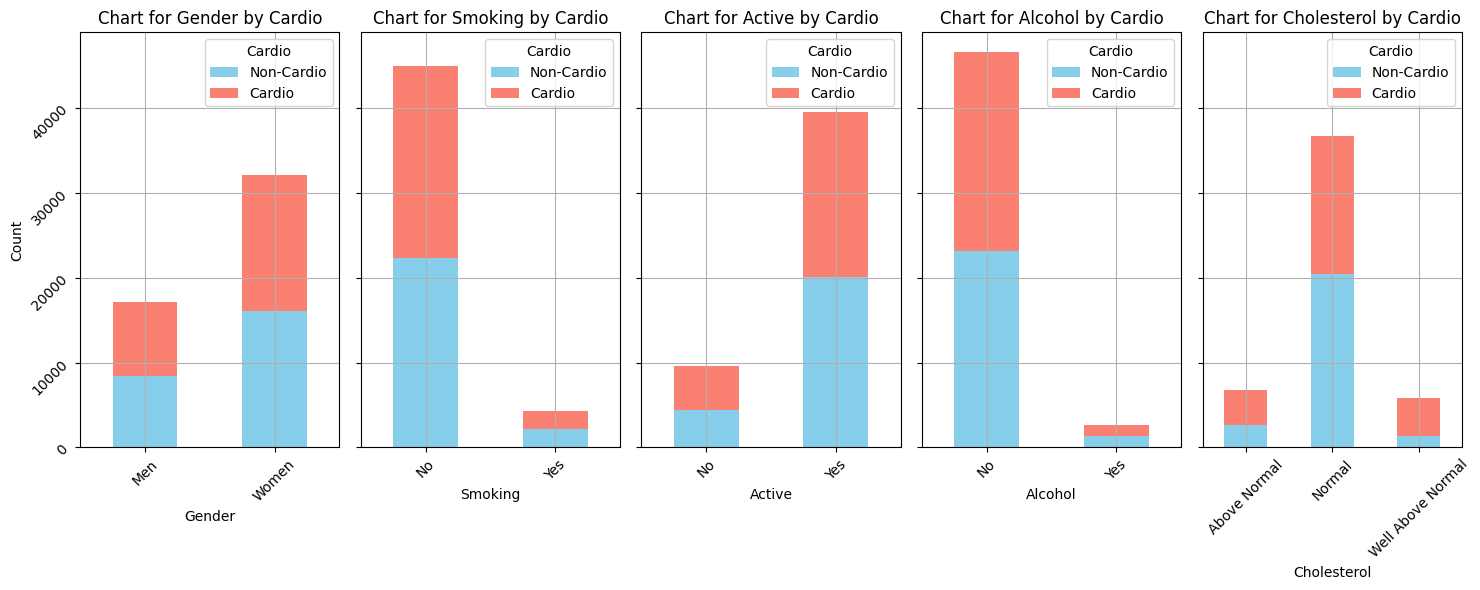

In [43]:
plot_bar(training_binned, ['Gender', 'Smoking', 'Active', 'Alcohol', 'Cholesterol'], 'Cardio')

The above bar plots shows the distribution of our categorical value levels and their relationship with the Cardio variable(cardio means there is heart disease, non-cardio means there is not).
From the above observations we can see that a well above normal cholesterol appear to have a higher risk of cardiovascualar issues.Similarly, those with high blood pressure (stage 2) and hypertensive crises also appear to be at risk. On the opposite spectrum, those with elevated and normal blood pressure appear to be less at risk.

#Modelling

Creating functions which help in building preprocessing pipeline and data modelling

In [44]:
def build_pipeline(df):
    num_cols = ['Age','Height', 'Weight']
    cat_cols = ['Glucose', 'Gender', 'Cholesterol', 'Smoking', 'Active', 'Alcohol', 'SystolicBP_Group', 'DiastolicBP_Group']
    label_col = "Cardio"
    df = bin_bp(df)
    indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in cat_cols]
    encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in cat_cols]
    input_cols = num_cols + [col+"_encoded" for col in cat_cols]
    assembler = VectorAssembler(inputCols=input_cols, outputCol="assembled_features")
    label_indexer = StringIndexer(inputCol=label_col, outputCol="label")
    scaler = StandardScaler(inputCol="assembled_features", outputCol="features")
    stages = [assembler, label_indexer, scaler]
    pipeline = Pipeline(stages=indexers + encoders + stages)
    pipeline_model = pipeline.fit(df)
    return pipeline_model.transform(df).select('features', 'label'), pipeline_model

In [45]:
def data_modeling(df, model):
    df = bin_bp(df)
    return model.transform(df).select('features', 'label')

In [46]:
classifiers = {
    "Logistic Regression": {
        "classifier": LogisticRegression(),
        "params": {
            "regParam": [0, 0.001, 0.01, 0.1, 1, 10],
            "elasticNetParam": [0, 1],
            "maxIter": [20, 50, 100, 200]
        }
    },
    "Decision Tree": {
        "classifier": DecisionTreeClassifier(),
        "params": {
            "maxBins": [2, 4, 8, 16, 32],
            "maxDepth": [2, 5, 10]
        }
    },
    "Random Forest": {
        "classifier": RandomForestClassifier(seed=123),
        "params": {
            "featureSubsetStrategy": ['auto', 'all', 'onethird', 'sqrt', 'log2'],
            "maxBins": [2, 4, 8, 16, 32],
            "maxDepth": [2, 5, 10],
            "numTrees": [5, 10, 20, 50]
        }
    }
    }

In [47]:
tr, pipeline_model = build_pipeline(training)
ts = data_modeling(test, pipeline_model)

In [51]:
results = []
for classifier_name, classifier in classifiers.items():
    print(f"Executing classifier: {classifier_name}")
    print('----------------------------------')
    estimator = classifier["classifier"]
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    # Train the model directly
    model = estimator.fit(tr)
    predictions = model.transform(ts)

    # Compute accuracy
    accuracy = evaluator.evaluate(predictions)

    # Compute log loss
    evaluator.setMetricName("logLoss")
    log_loss = evaluator.evaluate(predictions)

    # Collect model parameters
    features_str = ""
    for param_name, param_values in classifier["params"].items():
        mod_param_name = "get" + param_name[0].upper() + param_name[1:]
        param_attr = getattr(model, mod_param_name, None)
        if callable(param_attr):
            param_attr = param_attr()
        features_str = features_str + f"{param_name}: {param_attr} |"
    features_str = features_str.rstrip('|')

    results.append((classifier_name, round(accuracy, 4), round(log_loss, 4), features_str))


Executing classifier: Logistic Regression
----------------------------------
Executing classifier: Decision Tree
----------------------------------
Executing classifier: Random Forest
----------------------------------


In [52]:
columns = ["Classifier", "Accuracy", "Log Loss", "Features"]
results_df = pd.DataFrame(results, columns=columns)
print(results_df.to_markdown(index=False))

| Classifier          |   Accuracy |   Log Loss | Features                                                            |
|:--------------------|-----------:|-----------:|:--------------------------------------------------------------------|
| Logistic Regression |     0.7351 |     0.5492 | regParam: 0.0 |elasticNetParam: 0.0 |maxIter: 100                   |
| Decision Tree       |     0.7254 |     0.5595 | maxBins: 32 |maxDepth: 5                                            |
| Random Forest       |     0.7264 |     0.5587 | featureSubsetStrategy: auto |maxBins: 32 |maxDepth: 5 |numTrees: 20 |


Here, we can see Logistic Regression giving the best results with lowest log loss and highest accuracy.